# SeRANIS Trade-off Analysis for Orbits

In this notebook, we set up an Orbit simulation to compute coverage, eclipse, observation times, propulsion requirements etc for Sun Synchronous Orbit (SSO) and an orbit inclined to match the latitude of Neubiberg.

## Python Imports

In [1]:
# python imports
import numpy as np
import matplotlib.pyplot as plt
import datetime
import orekit
import logging
import math
import cartopy.crs as ccrs

## Orekit Imports
Keep all orekit imports below.

In [2]:
# orekit imports
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime, datetime_to_absolutedate
from org.hipparchus.geometry.euclidean.threed import Line
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.utils import Constants, PVCoordinates, ExtendedPVCoordinatesProvider
from org.orekit.bodies import CelestialBodyFactory, OneAxisEllipsoid, GeodeticPoint
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.time import TimeScalesFactory
from org.orekit.orbits import KeplerianOrbit, PositionAngle, OrbitType, CircularOrbit, EquinoctialOrbit
from org.orekit.propagation import SpacecraftState, PropagatorsParallelizer
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel, ThirdBodyAttraction
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.drag import IsotropicDrag, DragForce
from org.orekit.forces.radiation import IsotropicRadiationClassicalConvention, SolarRadiationPressure
from org.orekit.models.earth.atmosphere import HarrisPriester
from org.orekit.utils import IERSConventions
from org.orekit.propagation.events import EclipseDetector, EventDetector, ElevationDetector
from org.orekit.propagation.sampling import PythonOrekitFixedStepHandler
from org.orekit.propagation.events.handlers import EventHandler, PythonEventHandler
from org.orekit.propagation.events.handlers import ContinueOnEvent
from org.hipparchus.ode.events import Action
from org.orekit.forces import BoxAndSolarArraySpacecraft
from orekit import JArray_double


## Set up Orekit

In [3]:
# initialize virtual machine
vm = orekit.initVM()
# change path when changing machine or use relative path
# laptop_path ="C:/Users/Mohd Bilal/Documents/Bilal/VSCodeWorkspace/seranis_mission_simulator/orekit-data.zip"
# pc_path = "E:/VSCodeWorkspace/seranis_mission_simulator/orekit-data.zip"
setup_orekit_curdir("../../../../orekit-data.zip")

## Define some helper functions for time conversion.

In [5]:
def UTC2JD(UTC):
    """
    calculates the Julian Day given UTC
    parameters: UTC - dateUTC.dateUTC
    return : Julian day i.e., days from 4713 BC
    """
    JD = 367 * UTC.year - int(7 * (UTC.year + int(
        (UTC.month + 9) / 12)) / 4) + int(
            275 * UTC.month / 9) + UTC.day + 1721013.5 + (
                (UTC.second / 60.0 + UTC.minute) / 60.0 + UTC.hour) / 24.0
    return JD


def JDC2GMST(t_cent):
    """
    return: Greenwich Mean Sidereal Time given the centuries of the Julian Day of the UTC
    values returned in radians
    """
    theta_gmst = 67310.54841 + (876600 * 3600 +
                                8640184.812866) * t_cent + 0.093104 * (
                                    t_cent**2) - 6.2 * 1e-6 * (t_cent**3)
    theta_gmst = theta_gmst % 86400 - 86400
    theta_gmst_deg = theta_gmst / 240
    if theta_gmst < 0:
        theta_gmst_deg = 360 + theta_gmst_deg
    return np.deg2rad(theta_gmst_deg)

def get_julian_centuries(JD):
    return (JD - 2451545)/36525


In [18]:
def sso_orbit(**kwargs):
    """Computes keplerian elements of sunsynchronous orbit given the type of sso orbit.
    All units are SI.
    The function computes the secular rate of raan ignoring the short periodics and long periodics for a 2x2 geopotential field.
    The perturbing force is averaged over one revolution i.e. int_m0_m2pi
    It does not matter whether osculating or mean elements are used to evaluate the secular rate of change
    of raan because the variations are of the order J2^2, and our first order theory already neglected J2^2 values. But ideally we should use
    mean elements because the theory was developed by computing the mean rates.
    Rees (1963) extended RAAN secular to J14 effects. 
    """
    Re = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
    J2 = 1082e-6
    mu = 3.98600442e14 #Constants.WGS84_EARTH_MU
    raandot = 1.991063853e-7
    k = -3*Re**2*J2*np.sqrt(mu)/(2*raandot)

    a = kwargs["a"] if "a" in kwargs else None
    i = kwargs["i"] if "i" in kwargs else None
    e = kwargs["e"] if "e" in kwargs else None
    time = kwargs["time"] if "time" in kwargs else datetime.datetime.utcnow()
    hrs_from_noon = kwargs["hrs_from_noon"] if "hrs_from_noon" in kwargs else 0.0


    if e is not None and i is not None:
        a = np.power(k*np.cos(i)/((1-e**2)**2), 2.0/7.0)
    elif e is not None and a is not None:
        i = np.arccos(np.power(a, 7.0/2.0)*(1-e**2)**2/k)
    elif a is not None and i is not None:
        e = np.sqrt(1 - np.sqrt(k*np.cos(i)/a**(7.0/2.0)))
    else:
        raise ValueError("Insufficient arguments to compute sso. Provide either of (a,i), (a,e), (e,i).")

    ## Compute RAAN given type of SSO
    eme = FramesFactory.getEME2000()
    sun = CelestialBodyFactory.getSun()
    sun_pv = ExtendedPVCoordinatesProvider.cast_(sun)
    sun_coordinates = sun_pv.getPVCoordinates(datetime_to_absolutedate(time), eme)
    sun_position = np.array([sun_coordinates.getPosition().getX(), sun_coordinates.getPosition().getY(), sun_coordinates.getPosition().getZ()])
    theta_sun = np.arccos(sun_position[0]/np.linalg.norm(sun_position))
    print(theta_sun)
    raan = theta_sun + hrs_from_noon*2*np.pi/24.0
    if raan < 0:
        raan = 2*np.pi + raan
    return a, e, i, raan

In [6]:
def repeating_orbit_leo(i, ndays, **kwargs):
    """computes keplerian elements of repeating orbit from given conditions
    """
    # constants
    Re = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
    J2 = 1082e-6
    mu = 3.98600442e14
    wE = 2*np.pi/86400.0

    a = kwargs["a"] if "a" in kwargs else (Re + 500e3)
    e = kwargs["e"] if "e" in kwargs else 0.0
    max_iter = kwargs["max_iter"] if "max_iter" in kwargs else 20
    
    k = (3*J2*Re**2)/2.0
    p = a*(1-e**2)

    anomalistic_period = 2*np.pi*np.sqrt(a**3/mu) # period from perigee to perigee
    nodal_period = anomalistic_period * (1 - k*(3 - 4*(np.sin(i))**2)/a**2)

    mean_motion = 2*np.pi/anomalistic_period
    j2k = 1.5*mean_motion*J2*(Re/p)**2
    raandot = -j2k*np.cos(i)

    # m = np.floor(2*np.pi*ndays/((wE - raandot)*nodal_period)) # number of revolutions
    m = 2*np.pi*ndays/((wE - raandot)*nodal_period) # number of revolutions
    
    rpd = m/ndays

    mean_motion = rpd*(wE)
    a_new = np.power(mu*(1/mean_motion**2), 1.0/3.0)

    iteration = 0
    tolerance = 1e3
    
    while (np.abs(a_new - a) > tolerance) or iteration <  max_iter:
        a = a_new
        p = a*(1-e**2)
        j2k = 1.5*mean_motion*J2*(Re/p)**2
        raandot = -j2k*np.cos(i)
        omegadot = j2k*(4-5*np.sin(i)**2)/2
        mdot = j2k*np.sqrt(1-e**2)*(2-3*np.sin(i)**2)/2
        # mean_motion = rpd*(wE - raandot) - omegadot -mdot
        mean_motion = rpd*(wE - raandot)*(1 - 1.5*J2*(Re/a)**2*(3 - 4*np.sin(i)**2))
        a_new = np.power(mu*(1/mean_motion**2), 1.0/3.0)
        iteration += 1
    
    return a, rpd

### Test Custom Defined Functions

#### Test `sso_orbit`

In [7]:
mu_sso = np.deg2rad(48)
time_neubiberg_local = datetime.datetime(2021, 8, 16, 18, 0, 0, 0) - datetime.timedelta(seconds=86400*mu_sso/(2*np.pi))
time_utc = time_neubiberg_local - datetime.timedelta(hours=2)

In [8]:
# a, e, i, raan = sso_orbit(a=(6378.1363 + 567.45129)*1e3, i=np.deg2rad(97.7))
# a, e, i, raan = sso_orbit(a=(6378.1363 + 567.45129)*1e3, e=0.0)
# a, e, i, raan = sso_orbit(e=0.0, i=np.deg2rad(97.66497041))
a, e, i, raan = sso_orbit(e=0.0, i=np.deg2rad(97.66497041), hrs_from_noon=-6.0, time=time_utc) # Dawn Dusk Orbit
print(f"sma: {a/1e3}, height: {a/1e3 - 6378.1363}, eccentricity:{e}, inclination: {np.rad2deg(i)}, raan: {np.rad2deg(raan)}")

sma: 6945.588024099379, height: 567.4517240993791, eccentricity:0.0, inclination: 97.66497041, raan: 53.58276586241716


### LEO regimes

In [9]:
heights = np.arange(100e3, 1000e3, 1e3) # heights are at perigee
ecc_max = (Constants.WGS84_EARTH_EQUATORIAL_RADIUS + 2000e3)
eccs = np.arange(0, 0.15, 0.005)
i_dd_all = np.zeros((heights.shape[0], eccs.shape[0]))
raan_all = np.zeros((heights.shape[0], eccs.shape[0]))
apogee_heights = np.zeros((heights.shape[0], eccs.shape[0]))
for i in range(heights.shape[0]):
    for j in range(eccs.shape[0]):
        ecc_set = eccs[j]
        sma_set =(Constants.WGS84_EARTH_EQUATORIAL_RADIUS + heights[i])/(1- ecc_set)
        apogee_heights[i, j] = sma_set*(1+ecc_set) - Constants.WGS84_EARTH_EQUATORIAL_RADIUS

(0.0, 0.15)

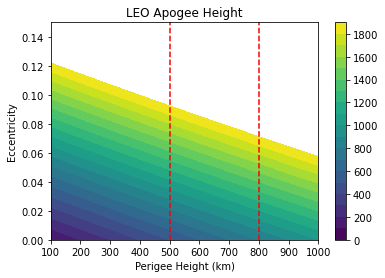

In [10]:
fig_leo=plt.figure("LEO Eccentricity Range")
ax_leo=fig_leo.add_subplot(111)
c_dd = ax_leo.contourf(heights/1e3, eccs, apogee_heights.T/1e3, levels=np.arange(0, 2000, 100))
fig_leo.colorbar(c_dd, ax=ax_leo)
ax_leo.set_title("LEO Apogee Height")
ax_leo.set_xlabel("Perigee Height (km)")
ax_leo.set_ylabel("Eccentricity")
ax_leo.plot(np.array([500, 500]), np.array([0, 0.15]), 'r', linestyle='dashed')
ax_leo.plot(np.array([800, 800]), np.array([0, 0.15]), 'r', linestyle='dashed')
ax_leo.set_xlim(120, 1000)
ax_leo.set_xticks(np.arange(100, 1100, 100))
ax_leo.set_ylim(0, 0.15)
# fig_leo.savefig("LEO Heights.png", format='png')

In [11]:
peri_heights_dd = np.arange(500e3, 800e3, 1e3) # peri_heights_dd are at perigee
eccs_dd = np.arange(0, 0.075, 0.001)
i_dd_all = np.zeros((peri_heights_dd.shape[0], eccs_dd.shape[0]))
raan_dd_all = np.zeros((peri_heights_dd.shape[0], eccs_dd.shape[0]))
apogee_heights_dd = np.zeros((peri_heights_dd.shape[0], eccs_dd.shape[0]))
for i in range(peri_heights_dd.shape[0]):
    for j in range(eccs_dd.shape[0]):
        ecc_set_dd = eccs_dd[j]
        sma_set_dd =(Constants.WGS84_EARTH_EQUATORIAL_RADIUS + peri_heights_dd[i])/(1- ecc_set_dd)
        apogee_heights_dd[i, j] = sma_set_dd*(1+ecc_set_dd) - Constants.WGS84_EARTH_EQUATORIAL_RADIUS
        assert apogee_heights_dd[i, j] <= Constants.WGS84_EARTH_EQUATORIAL_RADIUS + 2000e3
        sma, ecc, i_dd_all[i, j], raan_dd_all[i, j] = sso_orbit(e=ecc_set_dd, a=sma_set_dd, hrs_from_noon=-6.0) # Dawn Dusk Orbit

(500.0, 800.0)

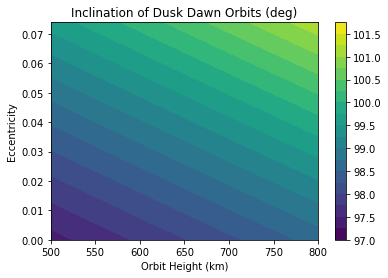

In [12]:
fig_dd=plt.figure("SSO Orbit Dusk Dawn")
ax_dd=fig_dd.add_subplot(111)
c_dd = ax_dd.contourf(peri_heights_dd/1000, eccs_dd, np.rad2deg(i_dd_all.T), levels=np.arange(97, 102, 0.25))
fig_dd.colorbar(c_dd, ax=ax_dd)
ax_dd.set_title("Inclination of Dusk Dawn Orbits (deg)")
ax_dd.set_xlabel("Orbit Height (km)")
ax_dd.set_ylabel("Eccentricity")
ax_dd.set_xlim(500, 800)
# fig_dd.savefig("SSO Orbit Inclination.png", format='png')

In [13]:
h_p = 567.45129e3
r_p = Constants.WGS84_EARTH_EQUATORIAL_RADIUS + h_p
e = 0.0
a = r_p/(1-e)
a, e, i, raan = sso_orbit(e=e, a=a, hrs_from_noon=-6.0) # Dawn Dusk Orbit
print(f"inclination: {np.rad2deg(i)}, raan: {np.rad2deg(raan)}")


inclination: 97.6649714432147, raan: 76.92839832010547


#### Test `repeating_orbit_leo`

### Inclination Regions for Repeating GT Orbit

In [33]:
inclinations_rgt = np.arange(np.deg2rad(48), np.deg2rad(90), np.deg2rad(1))
eccs_rgt = np.arange(0, 0.075, 0.001)
sma_rgt_all = np.zeros((inclinations_rgt.shape[0], eccs_rgt.shape[0]))
rpd_rgt_all = np.zeros((inclinations_rgt.shape[0], eccs_rgt.shape[0]))
perigee_heights_rgt = np.zeros((inclinations_rgt.shape[0], eccs_rgt.shape[0]))
ndays = 1
base_perigee_height = 500e3
for i in range(inclinations_rgt.shape[0]):
    for j in range(eccs_rgt.shape[0]):
        e = eccs_rgt[j]
        a_base = (Constants.WGS84_EARTH_EQUATORIAL_RADIUS + base_perigee_height)/(1-e)
        sma_rgt_all[i, j], rpd_rgt_all[i, j] = repeating_orbit_leo(inclinations_rgt[i], ndays=ndays, a=a_base, e=e)
        perigee_heights_rgt[i, j] = sma_rgt_all[i, j]*(1-e) - Constants.WGS84_EARTH_EQUATORIAL_RADIUS

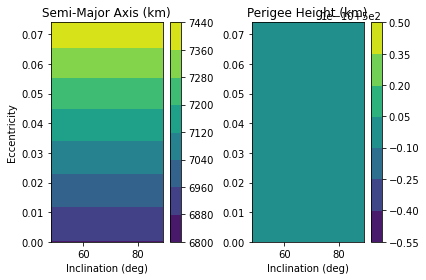

In [34]:
fig_rgt=plt.figure("1 Day RGT Orbit")


ax_rgt_sma=fig_rgt.add_subplot(121)
c_rgt_sma = ax_rgt_sma.contourf(np.rad2deg(inclinations_rgt), eccs_rgt, sma_rgt_all.T/1000)
fig_rgt.colorbar(c_rgt_sma, ax=ax_rgt_sma)
ax_rgt_sma.set_title("Semi-Major Axis (km)")
ax_rgt_sma.set_xlabel("Inclination (deg)")
# ax_rgt_sma.set_xticklabels(np.arange(48, 90, 20))
ax_rgt_sma.set_ylabel("Eccentricity")

ax_rgt=fig_rgt.add_subplot(122)
c_rgt = ax_rgt.contourf(np.rad2deg(inclinations_rgt), eccs_rgt, perigee_heights_rgt.T/1000)
fig_rgt.colorbar(c_rgt, ax=ax_rgt)
ax_rgt.set_title("Perigee Height (km)")
ax_rgt.set_xlabel("Inclination (deg)")
# ax_rgt.set_ylabel("Eccentricity")

plt.tight_layout()
# fig_rgt.savefig("1d_rgt_perigee.png", format='png')

In [35]:
base_perigee_height_rgt = 567e3
base_sma_rgt = Constants.WGS84_EARTH_EQUATORIAL_RADIUS + base_perigee_height_rgt
swath_half = np.arccos(Constants.WGS84_EARTH_EQUATORIAL_RADIUS/base_sma_rgt)
i_rgt = np.deg2rad(48.0747) + swath_half
a_rgt, revs_per_day_rgt = repeating_orbit_leo(i_rgt, ndays=1.0, a=base_sma_rgt,  e=0.00)
print(f"inclination: {np.rad2deg(i_rgt)}, sma: {a_rgt/1e3}, height: {(a_rgt - Constants.WGS84_EARTH_EQUATORIAL_RADIUS)/1e3}, rpd: {revs_per_day_rgt}")


inclination: 71.38718886134605, sma: 6945.136999999994, height: 566.9999999999944, rpd: 14.88993270249263


### Study effect of varying number of repeating days at fixed inclination

In [36]:
# a, rpd = repeating_orbit_leo(np.deg2rad(50), 10)
perigee_heights = np.arange(500e3, 800e3, 1e3)
repeating_days= np.arange(0.5, 10, 0.5)
sma_all = np.zeros((perigee_heights.shape[0], repeating_days.shape[0]))
rpd_all = np.zeros((perigee_heights.shape[0], repeating_days.shape[0]))

e = 0.0
sma_base_all = (Constants.WGS84_EARTH_EQUATORIAL_RADIUS + perigee_heights)/(1 - e)
swaths_all = np.arccos(Constants.WGS84_EARTH_EQUATORIAL_RADIUS/sma_base_all)
inclinations_all =  np.deg2rad(48.0747) + swaths_all

for i in range(perigee_heights.shape[0]):
    for j in range(repeating_days.shape[0]):
        # a_base = (Constants.WGS84_EARTH_EQUATORIAL_RADIUS + perigee_heights[i])/(1 - e) # only forc
        # swath_half = np.arccos(Constants.WGS84_EARTH_EQUATORIAL_RADIUS/a_base)
        # inclination = np.deg2rad(48.0747) + swath_half
        ndays = repeating_days[j]
        sma_all[i, j], rpd_all[i, j] = repeating_orbit_leo(inclinations_all[i], ndays=ndays, a=sma_base_all[i],  e=0.0)

height_all = (sma_all*(1-e) - Constants.WGS84_EARTH_EQUATORIAL_RADIUS)


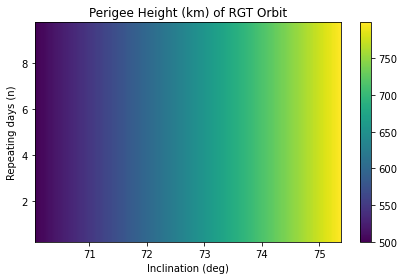

In [37]:
fig_repeating=plt.figure("Repeating Orbits")
ax_rh=fig_repeating.add_subplot(111)
c_rh = ax_rh.pcolormesh(np.rad2deg(inclinations_all), repeating_days, height_all.T/1e3,  shading='auto')
fig_repeating.colorbar(c_rh, ax=ax_rh)
ax_rh.set_xlabel("Inclination (deg)")
ax_rh.set_ylabel("Repeating days (n)")
ax_rh.set_title("Perigee Height (km) of RGT Orbit")
# fig_repeating.savefig("rgt_inclination_vs_nrepeat.png", format="png")

# ax_rd=fig_repeating.add_subplot(212)
# c_rd = ax_rd.pcolormesh(np.rad2deg(inclinations_all), repeating_days, rpd_all.T,  shading='auto')
# fig_repeating.colorbar(c_rd, ax=ax_rd)

plt.tight_layout()

## Define Simulation Time

In [6]:
start_time = datetime.datetime.utcnow()
duration = 5*86400
end_time = start_time + datetime.timedelta(seconds=duration)
time_step = 120.0

# convert to orekit times
start_time_ok = datetime_to_absolutedate(start_time)
duration_ok = float(duration)
end_time_ok = start_time_ok.shiftedBy(duration_ok)
time_step_ok = float(time_step)

## Define Central Body, Body Shape, Inertial Frame, Topocentric Frame, Ground Station

### Inertial Frame Definition

In [1]:
inertial_frame = FramesFactory.getEME2000()

NameError: name 'FramesFactory' is not defined

### Earth Frame Definition

In [8]:

earth_frame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

### Central Body and its Shape

In [9]:
# earth position velocity object
earth = CelestialBodyFactory.getEarth()
earth_pv = ExtendedPVCoordinatesProvider.cast_(earth)

# earth shape: an ellipsoid
earth_shape = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                               Constants.WGS84_EARTH_FLATTENING, earth_frame)


### Sun

In [10]:
sun =  CelestialBodyFactory.getSun()

### Ground Stations and Frames

#### Neubiberg Station

In [11]:
LATITUDE_NEUBIBERG = 48.0747
LONGITUDE_NEUBIBERG = 11.6715
ALTITUDE_NEUBIBERG = 550.0
station_neubiberg = GeodeticPoint(float(np.deg2rad(LATITUDE_NEUBIBERG)), float(np.deg2rad(LONGITUDE_NEUBIBERG)), ALTITUDE_NEUBIBERG)
station_neubiberg_frame = TopocentricFrame(earth_shape, station_neubiberg, "Neubiberg")

## Spacecraft Definitions

In [12]:
spacecrafts = []

## Define Initial States for Spacecraft

### Initial Orbit for Dawn Dusk Orbit

### Define times

In [21]:
# compute the time when sso orbit passes over Neubiberg (approximately)

mu_sso = np.deg2rad(LATITUDE_NEUBIBERG)
time_neubiberg_flyover = datetime.datetime(2021, 8, 18, 18, 29, 0, 0)
time_neubiberg_local_dd = time_neubiberg_flyover - datetime.timedelta(seconds=5760.6904 *(1 -  mu_sso / (2*np.pi))) # time of raan
time_utc_dd = time_neubiberg_flyover - datetime.timedelta(seconds=86400.0*np.deg2rad(LONGITUDE_NEUBIBERG)/(2*np.pi)) # utc does not consider day light saving time
start_time_dd = time_utc_dd

end_time_dd = start_time_dd + datetime.timedelta(seconds=duration)

start_time_ok_dd = datetime_to_absolutedate(start_time_dd)
end_time_ok_dd = start_time_ok_dd.shiftedBy(duration_ok)

In [22]:
# keeping circular orbit
MASS_DUSK_DAWN = float(117.0)

base_perigee_height_dd = 567.45129e3
base_e_dd = 0.0
base_sma_dd = (Constants.WGS84_EARTH_EQUATORIAL_RADIUS + base_perigee_height_dd) / (1 - base_e_dd)
a_dd, e_dd, i_dd, raan_dd = sso_orbit(a=base_sma_dd, e=base_e_dd, hrs_from_noon=-6.0, time=start_time_dd)

# match latitude to neubiberg
arc_neubiberg_dd = np.arcsin(np.sin(np.deg2rad(LATITUDE_NEUBIBERG)) / np.sin(i_dd))

initial_state_dusk_dawn = SpacecraftState(
    CircularOrbit(float(a_dd), float(0.0), float(0.0), float(i_dd), float(raan_dd),
        float(np.pi - arc_neubiberg_dd), PositionAngle.MEAN, inertial_frame,
        start_time_ok_dd,
        Constants.WGS84_EARTH_MU), MASS_DUSK_DAWN)
orbit_type_dd = OrbitType.CIRCULAR

3.0452742660790904


In [23]:
start_time_dd

datetime.datetime(2021, 9, 28, 17, 42, 18, 840000)

In [24]:
raan_dd

1.4744779392841938

In [25]:
start_time_ok_dd

<AbsoluteDate: 2021-09-28T17:42:18.840>

### Check Initial Orbit Projection on Earth

In [26]:
subsat_dd  = earth_shape.transform(initial_state_dusk_dawn.getPVCoordinates().getPosition(), inertial_frame, start_time_ok_dd)
subsat_dd

<GeodeticPoint: {lat: 48.2553044608 deg, lon: -0.0526721197 deg, alt: 579,314.634206654}>

### Initial Orbit for Repeating Orbit

#### Define Times

In [50]:
start_time_rgt = start_time
end_time_rgt = end_time

start_time_ok_rgt = start_time_ok
end_time_ok_rgt = end_time_ok

In [51]:
# keeping circular orbit

MASS_REPEATING = float(117.0)
base_perigee_height_rgt = 500e3
base_e_rgt = 0.0011
base_sma_rgt = (Constants.WGS84_EARTH_EQUATORIAL_RADIUS + base_perigee_height_rgt)/(1 - base_e_rgt)
ele_min_rgt = np.deg2rad(5)
rho_rgt = np.arcsin(Constants.WGS84_EARTH_EQUATORIAL_RADIUS/(Constants.WGS84_EARTH_EQUATORIAL_RADIUS + base_perigee_height_rgt))
eta_max_rgt = np.arcsin(np.sin(rho_rgt)*np.cos(ele_min_rgt))
lambda_max_rgt = np.pi/2 - ele_min_rgt - eta_max_rgt
# swath_half = np.arccos(Constants.WGS84_EARTH_EQUATORIAL_RADIUS/base_sma_rgt)
swath_half = lambda_max_rgt

i_rgt = np.deg2rad(LATITUDE_NEUBIBERG) + swath_half
a_rgt, revs_per_day_rgt = repeating_orbit_leo(i_rgt, ndays=1.0, a=base_sma_rgt,  e=base_e_rgt)
jd = UTC2JD(start_time)
theta_gmst = JDC2GMST(get_julian_centuries(jd))

arc_neubiberg_rgt = np.arcsin(np.sin(np.deg2rad(LATITUDE_NEUBIBERG)) / np.sin(i_rgt))

# satellite is over Neubiberg with this condition
long_raan_rgt = np.deg2rad(LONGITUDE_NEUBIBERG) - np.arccos(np.cos(arc_neubiberg_rgt) / np.cos(np.deg2rad(LATITUDE_NEUBIBERG)))
raan_rgt = theta_gmst + long_raan_rgt
perigee_rgt = arc_neubiberg_rgt

initial_state_rgt = SpacecraftState(
    EquinoctialOrbit(float(a_rgt), float(base_e_rgt*np.cos(arc_neubiberg_rgt + raan_rgt)), float(base_e_rgt*np.sin(arc_neubiberg_rgt + raan_rgt)), float(np.tan(i_rgt/2)*np.cos(raan_rgt)),
                  float(np.tan(i_rgt/2)*np.sin(raan_rgt)), float(raan_rgt + arc_neubiberg_rgt), PositionAngle.MEAN,
                  inertial_frame, start_time_ok_rgt, Constants.WGS84_EARTH_MU),
    MASS_REPEATING)

orbit_type_rgt = OrbitType.EQUINOCTIAL

In [52]:
(a_rgt*(1-base_e_rgt) - Constants.WGS84_EARTH_EQUATORIAL_RADIUS)/1e3

499.99999999999443

### Check Subsatellite Point Repeating Orbit

In [53]:
# subsatellite point must be neubiberg
subsat_rgt  = earth_shape.transform(initial_state_rgt.getPVCoordinates().getPosition(), inertial_frame, start_time_ok_rgt)
subsat_rgt

<GeodeticPoint: {lat: 48.1342144779 deg, lon: 11.9696733547 deg, alt: 511,818.0724057663}>

In [54]:
t_rgt = initial_state_rgt.getFrame().getTransformTo(earth_shape.getBodyFrame(), start_time_ok)
c_rgt = earth_shape.transform(t_rgt.transformPosition(initial_state_rgt.getPVCoordinates().getPosition()), earth_shape.getBodyFrame(), start_time_ok_rgt)
c_rgt

<GeodeticPoint: {lat: 48.1342144779 deg, lon: 11.9696733547 deg, alt: 511,818.0724057663}>

In [55]:
# matching flying laptop dimensions and solar area

# dusk dawn orbit won't need rotating solar panels. this can also be studied later. 
# to make sc panels fixed, rotation rate is set to zero
physical_sc_dusk_dawn = BoxAndSolarArraySpacecraft(float(0.60), float(0.702),
                                                  float(0.865), sun,
                                                  float(30.18e-4),
                                                  Vector3D.PLUS_J,
                                                  start_time_ok_dd,
                                                  Vector3D.MINUS_K, float(0.0),
                                                  float(2.25), float(0.5),
                                                  float(0.5))

# repeating ground track orbit has rotating solar panels. lighting conditions are made to be optimal
physical_sc_repeating = BoxAndSolarArraySpacecraft(float(0.60), float(0.702),
                                                  float(0.865), sun,
                                                  float(30.18e-4),
                                                  Vector3D.PLUS_J, float(2.25),
                                                  float(0.5), float(0.5))

## Define Environment

### Gravity Force

In [56]:
gravity_force_dd = HolmesFeatherstoneAttractionModel(earth_frame, GravityFieldFactory.getNormalizedProvider(10, 10))
gravity_force_rgt = HolmesFeatherstoneAttractionModel(earth_frame, GravityFieldFactory.getNormalizedProvider(10, 10))

### Third Body Perturbations

In [57]:
lunar_3b_perturbations_dd = ThirdBodyAttraction(CelestialBodyFactory.getMoon())
lunar_3b_perturbations_rgt = ThirdBodyAttraction(CelestialBodyFactory.getMoon())

solar_3b_perturbations_dd = ThirdBodyAttraction(sun)
solar_3b_perturbations_rgt = ThirdBodyAttraction(sun)

### Drag Force

In [58]:
drag_force_dusk_dawn = DragForce(HarrisPriester(sun, earth_shape, float(4.0)), physical_sc_dusk_dawn)
drag_force_repeating = DragForce(HarrisPriester(sun, earth_shape, float(4.0)), physical_sc_repeating)

###  Solar Radiation Pressure Force

In [59]:
srp_force_dusk_dawn = SolarRadiationPressure(sun, earth_shape.getEquatorialRadius(), physical_sc_dusk_dawn)
srp_force_repeating = SolarRadiationPressure(sun, earth_shape.getEquatorialRadius(), physical_sc_repeating)

## Propagator

### Integration Time steps

In [60]:
min_step = float(0.001)
max_step = float(10.0)

### Tolerances

In [61]:
position_tolerance = float(1.0)
orbit_type = OrbitType.KEPLERIAN
tolerances_dd = NumericalPropagator.tolerances(position_tolerance, initial_state_dusk_dawn.getOrbit(),
                                            orbit_type_dd)

tolerances_rgt = NumericalPropagator.tolerances(position_tolerance, initial_state_rgt.getOrbit(),
                                            orbit_type_rgt)

### Set Up Integrator

In [62]:
integator_dd = DormandPrince853Integrator(min_step, max_step,
                                       JArray_double.cast_(tolerances_dd[0]),
                                       JArray_double.cast_(tolerances_dd[1]))

integator_rgt = DormandPrince853Integrator(min_step, max_step,
                                       JArray_double.cast_(tolerances_rgt[0]),
                                       JArray_double.cast_(tolerances_rgt[1]))

### Create Propagators

In [63]:
propagator_dusk_dawn = NumericalPropagator(integator_dd)
propagator_dusk_dawn.setOrbitType(orbit_type_dd)


propagator_repeating = NumericalPropagator(integator_rgt)
propagator_repeating.setOrbitType(orbit_type_rgt)

### Add Forces to Propagators

In [64]:
propagator_dusk_dawn.addForceModel(gravity_force_dd)
propagator_dusk_dawn.addForceModel(lunar_3b_perturbations_dd)
propagator_dusk_dawn.addForceModel(solar_3b_perturbations_rgt)
propagator_dusk_dawn.addForceModel(drag_force_dusk_dawn)
propagator_dusk_dawn.addForceModel(srp_force_dusk_dawn)


propagator_repeating.addForceModel(gravity_force_rgt)
propagator_repeating.addForceModel(lunar_3b_perturbations_rgt)
propagator_repeating.addForceModel(solar_3b_perturbations_rgt)
propagator_repeating.addForceModel(drag_force_repeating)
propagator_repeating.addForceModel(srp_force_repeating)

### Initialize Propagators

In [65]:
propagator_dusk_dawn.setInitialState(initial_state_dusk_dawn)

In [66]:
propagator_repeating.setInitialState(initial_state_rgt)

In [67]:
propagators = [propagator_dusk_dawn, propagator_repeating]

### Define Propagation Handler

In [68]:

class PropagationHandler(PythonOrekitFixedStepHandler):
    
    def __init__(self, inertial_frame, earth_shape, station_frame, min_el, camera_angle):
        self.inertial_frame = inertial_frame  
        self.earth_shape = earth_shape
        self.station_frame = station_frame
        self.min_el = min_el
        self.camera_angle = camera_angle

        self.dates = []
        self.centers = []

        self.inertial_pos = []
        self.inertial_vel = []

        self.elevations = []
        self.fp_area = []
        self.access_area = []
        self.camera_angle = camera_angle
        # Initialize the superclass as well
        super(PropagationHandler, self).__init__()
            
    def init(self, s0, t, step):
        # needs to be stated to fulfill the interface specification
        pass
    
    def handleStep(self, currentState, isLast):
        if isLast:
            print("propagation ended.")

        date = currentState.getDate()
        pv_inertial = currentState.getPVCoordinates()
        t = currentState.getFrame().getTransformTo(self.earth_shape.getBodyFrame(), date)
        p = t.transformPosition(pv_inertial.getPosition())
        v = t.transformVector(pv_inertial.getVelocity())
        center = self.earth_shape.transform(p, self.earth_shape.getBodyFrame(), date)

        self.dates.append(date)
        self.centers.append(center)

        sc_inertial_pos = [pv_inertial.getPosition().getX(), pv_inertial.getPosition().getY(), pv_inertial.getPosition().getZ()]
        self.inertial_pos.append(sc_inertial_pos)
        
        # compute elevation
        elevation = self.station_frame.getElevation(pv_inertial.getPosition(), self.inertial_frame, date)
        self.elevations.append(elevation)

        # compute footprint area
        sc2earth_dist = np.linalg.norm(sc_inertial_pos)
        sin_rho = self.earth_shape.getEquatorialRadius()/sc2earth_dist
        epsilon = np.arccos(np.sin(self.camera_angle)/sin_rho)
        lambda_nadir = np.pi/2 - epsilon - self.camera_angle
        height_cone = self.earth_shape.getEquatorialRadius()*(1 - np.cos(lambda_nadir))
        fp_area = 2*np.pi*self.earth_shape.getEquatorialRadius()*height_cone
        self.fp_area.append(fp_area)

        # compute access area
        nadir_angle_max = np.arcsin(sin_rho * np.cos(self.min_el))
        central_angle_max = np.pi/2 - self.min_el - nadir_angle_max
        access_area = 2.55604187e8*(1 - np.cos(central_angle_max))
        self.access_area.append(access_area)


### Define Event Handlers

#### Eclipse Event

In [69]:
class myNightEclipseDetector(PythonEventHandler):
    def __init__(self):
        super(myNightEclipseDetector, self).__init__()
        self.night_starts = []
    
    def init(self, s, T):
        pass
    
    def eventOccurred(self, s, detector, increasing):
        if not increasing:
            print("\n", s.getDate()," : event occurred, entering eclipse => switching to night law\n")
            self.night_starts.append(absolutedate_to_datetime(s.getDate()))
        return Action.CONTINUE
    
    def resetState(self, detector, oldState):
        return oldState


class myDayEclipseDetector(PythonEventHandler):
    def __init__(self):
        super(myDayEclipseDetector, self).__init__()
        self.night_ends = []
    
    def init(self, s, T):
        pass
    
    def eventOccurred(self, s, detector, increasing):
        if increasing:
            print("\n", s.getDate()," : event occurred, exiting eclipse => switching to day law\n")
            self.night_ends.append(absolutedate_to_datetime(s.getDate()))
        return Action.CONTINUE
    
    def resetState(self, detector, oldState):
        return oldState


#### Elevation Event

In [70]:
class ElevationDetectorHandler(PythonEventHandler):
    def __init__(self, inertial_frame, station_frame):
        super(ElevationDetectorHandler, self).__init__()
        self.times = {"start":[], "end":[]}
        self.station_frame = station_frame
        self.inertial_frame = inertial_frame

    def init(self, s, T):
        pass

    def eventOccurred(self, s, detector, increasing):
        # det = EclipseDetector.cast_(detector)
        ele = self.station_frame.getElevation(s.getPVCoordinates().getPosition(), self.inertial_frame, s.getDate())
        if increasing:
            print(f"Spacecraft in view of station")
            self.times["start"].append(absolutedate_to_datetime(s.getDate()))
        else:
            print("Spacecraft out of view...")
            self.times["end"].append(absolutedate_to_datetime(s.getDate()))
        return Action.CONTINUE

    def resetState(self, detector, oldState):
        return oldState

### Attach Event Handlers

In [71]:
CAMERA_HALF_ANGLE = np.deg2rad(20.0) # this is dummy value in degrees.
MIN_ELEVATION = np.deg2rad(5.0)

#### Attach Propagation Handlers

In [72]:
phandler_dd = PropagationHandler(inertial_frame=inertial_frame,
                                 earth_shape=earth_shape,
                                 station_frame=station_neubiberg_frame,
                                 min_el=float(MIN_ELEVATION),
                                 camera_angle=float(CAMERA_HALF_ANGLE))
phandler_rgt = PropagationHandler(inertial_frame=inertial_frame,
                                  earth_shape=earth_shape,
                                  station_frame=station_neubiberg_frame,
                                  min_el=float(MIN_ELEVATION),
                                  camera_angle=float(CAMERA_HALF_ANGLE))


#### Attach Elevation Detector Handler

In [73]:
elehandler_dd = ElevationDetectorHandler(
    station_frame=station_neubiberg_frame,
    inertial_frame=inertial_frame).of_(ElevationDetector)
eleevent_dd = ElevationDetector(station_neubiberg_frame).withConstantElevation(
    float(MIN_ELEVATION)).withHandler(elehandler_dd)
propagator_dusk_dawn.addEventDetector(eleevent_dd)

In [74]:
elehandler_rgt = ElevationDetectorHandler(
    station_frame=station_neubiberg_frame,
    inertial_frame=inertial_frame).of_(ElevationDetector)
eleevent_rgt = ElevationDetector(
    station_neubiberg_frame).withConstantElevation(
        float(MIN_ELEVATION)).withHandler(elehandler_rgt)
propagator_repeating.addEventDetector(eleevent_rgt)

#### Attach Eclipse Detector Handler

In [75]:

# day_night_event_handler_dd = myNightEclipseDetector().of_(EclipseDetector)
# day_night_event_dd =  EclipseDetector(sun, float(696000000.0), earth_shape).withHandler(day_night_event_handler_dd)

# night_day_event_handler_dd = myDayEclipseDetector().of_(EclipseDetector)
# night_day_event_dd = EclipseDetector(sun, float(696000000.0), earth_shape).withHandler(night_day_event_handler_dd)

# propagator_dusk_dawn.addEventDetector(day_night_event_dd)
# propagator_dusk_dawn.addEventDetector(night_day_event_dd)

# day_night_event_dd = EclipseDetector(CelestialBodyFactory.getSun(), float(696000000.0), OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, Constants.WGS84_EARTH_FLATTENING, earth_frame))
# day_night_event_dd = day_night_event_dd.withHandler(myNightEclipseDetector().of_(EclipseDetector))

# night_day_event_dd = EclipseDetector(CelestialBodyFactory.getSun(), float(696000000.0), OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, Constants.WGS84_EARTH_FLATTENING, earth_frame))
# night_day_event_dd = night_day_event_dd.withHandler(myDayEclipseDetector().of_(EclipseDetector))

# propagator_dusk_dawn.addEventDetector(day_night_event_dd)
# propagator_dusk_dawn.addEventDetector(night_day_event_dd)

In [76]:
day_night_event_handler_rgt = myNightEclipseDetector().of_(EclipseDetector)
day_night_event_rgt =  EclipseDetector(sun, float(696000000.0), earth_shape).withHandler(day_night_event_handler_rgt)

night_day_event_handler_rgt = myDayEclipseDetector().of_(EclipseDetector)
night_day_event_rgt = EclipseDetector(sun, float(696000000.0), earth_shape).withHandler(night_day_event_handler_rgt)

propagator_repeating.addEventDetector(day_night_event_rgt)
propagator_repeating.addEventDetector(night_day_event_rgt)

# day_night_event_rgt = EclipseDetector(sun, float(696000000.0), earth_shape)
# day_night_event_rgt = day_night_event_rgt.withHandler(myNightEclipseDetector().of_(EclipseDetector))

# night_day_event_rgt = EclipseDetector(sun, float(696000000.0), earth_shape)
# night_day_event_rgt = night_day_event_rgt.withHandler(myDayEclipseDetector().of_(EclipseDetector))

# propagator_repeating.addEventDetector(day_night_event_rgt)
# propagator_repeating.addEventDetector(night_day_event_rgt)

## Start Propagation

In [77]:
propagator_dusk_dawn.setMasterMode(time_step_ok, phandler_dd)
propagator_repeating.setMasterMode(time_step_ok, phandler_rgt)

### Propagate Dusk Dawn

In [78]:
propagator_dusk_dawn.propagate(start_time_ok_dd, end_time_ok_dd)

Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of station
Spacecraft out of view...
Spacecraft in view of 

<SpacecraftState: SpacecraftState{orbit=circular parameters: {a: 6937316.763737856, ex: -0.0011983317817851424, ey: -0.001174215372088366, i: 97.67430775445659, raan: 60.54745984810549, alphaV: 27087.447451993055;}, attitude=org.orekit.attitudes.Attitude@65382d45, mass=117.0, additional={}}>

### Propagate Repeating GT

In [79]:
propagator_repeating.propagate(start_time_ok_rgt, end_time_ok_rgt)

Spacecraft out of view...

 2021-09-02T12:11:16.422  : event occurred, entering eclipse => switching to night law


 2021-09-02T12:46:15.878  : event occurred, exiting eclipse => switching to day law

Spacecraft in view of station
Spacecraft out of view...

 2021-09-02T13:46:10.608  : event occurred, entering eclipse => switching to night law


 2021-09-02T14:21:09.147  : event occurred, exiting eclipse => switching to day law

Spacecraft in view of station
Spacecraft out of view...

 2021-09-02T15:21:04.835  : event occurred, entering eclipse => switching to night law


 2021-09-02T15:56:02.419  : event occurred, exiting eclipse => switching to day law

Spacecraft in view of station
Spacecraft out of view...

 2021-09-02T16:55:59.146  : event occurred, entering eclipse => switching to night law


 2021-09-02T17:30:55.738  : event occurred, exiting eclipse => switching to day law

Spacecraft in view of station

 2021-09-02T18:30:53.449  : event occurred, entering eclipse => switching t

<SpacecraftState: SpacecraftState{orbit=equinoctial parameters: {a: 6894617.830553846; ex: -0.002222995114239372; ey: 5.765617404294823E-4; hx: -0.3727428776540939; hy: 0.526163815476736; lv: 27502.880482691296;}, attitude=org.orekit.attitudes.Attitude@b87032e, mass=117.0, additional={}}>

## Analysis

In [80]:
time_vec = [start_time + datetime.timedelta(seconds=s) for s in range(0, int(duration + time_step), int(time_step))]

In [81]:
def geoline(geopoints):
    lon = [math.degrees(x.getLongitude()) for x in geopoints]
    lat = [math.degrees(x.getLatitude()) for x in geopoints]
    return lon, lat

### Analyze Dusk Dawn

#### Ground Track Plot

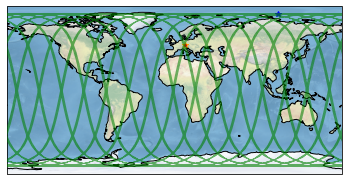

In [82]:
fig_gt_dd = plt.figure("Ground Track SSO")
ax_gt_dd = plt.axes(projection=ccrs.PlateCarree())
ax_gt_dd.coastlines()
# ax_gt_dd.gridlines()
ax_gt_dd.stock_img()
lon_gt_dd, lat_gt_dd = geoline(phandler_dd.centers)
ax_gt_dd.plot(lon_gt_dd, lat_gt_dd, transform=ccrs.Geodetic(), alpha=0.6, color='green', zorder=3, linewidth=0.5)
ax_gt_dd.plot(lon_gt_dd[0], lat_gt_dd[0], transform=ccrs.Geodetic(), marker="*", color="orange")
ax_gt_dd.plot(lon_gt_dd[-1], lat_gt_dd[-1], transform=ccrs.Geodetic(), marker="*", color="blue")
ax_gt_dd.plot(LONGITUDE_NEUBIBERG, LATITUDE_NEUBIBERG, transform=ccrs.Geodetic(), marker="o", color="red", markersize=2)

# fig_gt_dd.savefig("ground_track_dusk_dawn.png", format="png")

#### Elevation from Neubiberg

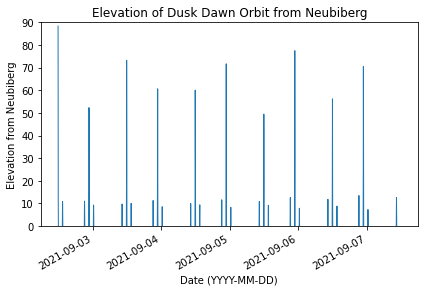

In [83]:
fig_ele_dd = plt.figure("Elevation Neubiberg SSO")
ax_ele_dd = fig_ele_dd.add_subplot(111)
ax_ele_dd.plot(time_vec, np.rad2deg(phandler_dd.elevations), linewidth=1.0)
ax_ele_dd.set_xlabel("Date (YYYY-MM-DD)")
ax_ele_dd.set_ylabel("Elevation from Neubiberg")
ax_ele_dd.set_title("Elevation of Dusk Dawn Orbit from Neubiberg")
ax_ele_dd.set_ylim(0, 90, 1)
plt.tight_layout()
fig_ele_dd.autofmt_xdate()

# fig_ele_dd.savefig("elevation_dd.png", format="png")

#### Overpasses

fraction of time in view of Dusk Dawn Orbit: 0.03021490823148148
average overpass time of Dusk Dawn Orbit: 7.251577975555555 mins


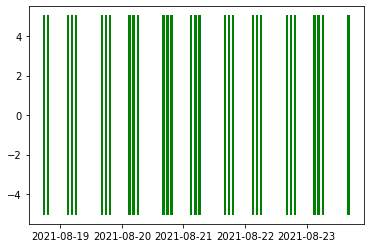

In [84]:
fig_tv_dd = plt.figure("Time in View SSO")
ax_tv_dd = fig_tv_dd.add_subplot(111)

visibility_start_dd = elehandler_dd.times.get("start").copy()
visibility_end_dd = elehandler_dd.times.get("end").copy()
tv_dd = []

if visibility_start_dd[0] > visibility_end_dd[0]:
    visibility_start_dd.insert(0, start_time_dd)

for tv_start_dd, tv_end_dd in zip(visibility_start_dd, visibility_end_dd):
    ax_tv_dd.plot([tv_start_dd, tv_start_dd], [-5, 5], color='green', linewidth=2)
    ax_tv_dd.plot([tv_start_dd, tv_end_dd], [0, 0], color='red', linewidth=1)
    ax_tv_dd.plot([tv_end_dd, tv_end_dd], [-5, 5], color='green', linewidth=2)
    tv_dd.append((tv_end_dd-tv_start_dd).total_seconds())

avg_tv_dd = np.mean(tv_dd)
fraction_tv_dd = np.sum(tv_dd)/duration
print(f"fraction of time in view of Dusk Dawn Orbit: {fraction_tv_dd}")
print(f"average overpass time of Dusk Dawn Orbit: {avg_tv_dd/60} mins")

#### Gap Times

In [85]:
gap_times_dd = np.array(visibility_start_dd[1:]) - np.array(visibility_end_dd[:-1])
gap_times_seconds_dd = [g.total_seconds() for g in gap_times_dd]
max_gap_time_dd = np.max(gap_times_seconds_dd)
time_avg_gap_dd = np.linalg.norm(gap_times_seconds_dd)**2/duration

print(f"Maximum gap time for Dawn Dusk Orbit: {max_gap_time_dd/3600} hrs")
print(f"Average gap time for Dawn Dusk Orbit: {time_avg_gap_dd/3600} hrs")

Maximum gap time for Dawn Dusk Orbit: 9.90169527861111 hrs
Average gap time for Dawn Dusk Orbit: 6.819421649814008 hrs


#### Coverage

##### Footprint Area

Average Footprint area of Dusk Dawn Orbit is 138367.62699793227 sq km


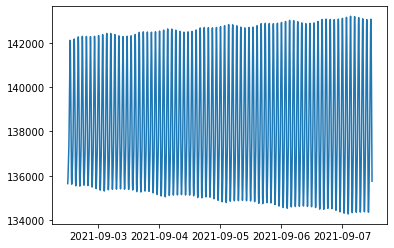

In [86]:
fig_fp_dd = plt.figure("Footprint Area Dawn Dusk")
ax_fp_dd = fig_fp_dd.add_subplot(111)
ax_fp_dd.plot(time_vec, np.array(phandler_dd.fp_area)/1e6)

print(f"Average Footprint area of Dusk Dawn Orbit is {np.mean(np.array(phandler_dd.fp_area))/1e6} sq km")

##### Access Area

Average Access area of Dawn Dusk Orbit is 13818389.974938467 sq km


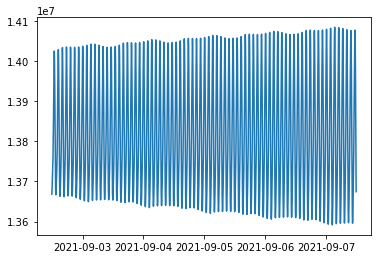

In [87]:
fig_ar_dd = plt.figure("Access Area Dawn Dusk")
ax_ar_dd = fig_ar_dd.add_subplot(111)
ax_ar_dd.plot(time_vec, phandler_dd.access_area) # access area in km2
print(f"Average Access area of Dawn Dusk Orbit is {np.mean(np.array(phandler_dd.access_area))} sq km")

#### Eclipse Durations

### Analyze Repeating GT

#### Ground Track Plot

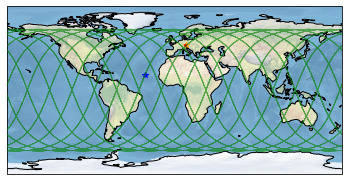

In [88]:
fig_gt_rgt = plt.figure("Ground Track RGT")
ax_gt_rgt = plt.axes(projection=ccrs.PlateCarree())
ax_gt_rgt.coastlines()
# ax_gt_rgt.gridlines()
ax_gt_rgt.stock_img()
lon_gt_rgt, lat_gt_rgt = geoline(phandler_rgt.centers)
ax_gt_rgt.plot(lon_gt_rgt, lat_gt_rgt, transform=ccrs.Geodetic(), alpha=0.6, color='green', zorder=3, linewidth=0.5)
ax_gt_rgt.plot(lon_gt_rgt[0], lat_gt_rgt[0], transform=ccrs.Geodetic(), marker="*", color="orange")
ax_gt_rgt.plot(lon_gt_rgt[-1], lat_gt_rgt[-1], transform=ccrs.Geodetic(), marker="*", color="blue")
ax_gt_rgt.plot(LONGITUDE_NEUBIBERG, LATITUDE_NEUBIBERG, transform=ccrs.Geodetic(), marker="o", color="red", markersize=2)

# fig_gt_rgt.savefig("ground_track_rgt.png", format="png")

#### Elevation from Neubiberg

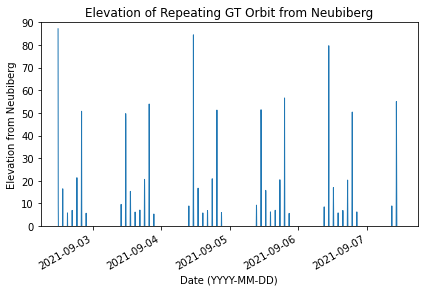

In [89]:
fig_ele_rgt = plt.figure("Elevation Neubiberg RGT")
ax_ele_rgt = fig_ele_rgt.add_subplot(111)
ax_ele_rgt.plot(time_vec, np.rad2deg(phandler_rgt.elevations), linewidth=1.0)
ax_ele_rgt.set_xlabel("Date (YYYY-MM-DD)")
ax_ele_rgt.set_ylabel("Elevation from Neubiberg")
ax_ele_rgt.set_title("Elevation of Repeating GT Orbit from Neubiberg")
ax_ele_rgt.set_ylim(0, 90, 1)
plt.tight_layout()
fig_ele_rgt.autofmt_xdate()

# fig_ele_rgt.savefig("elevation_rgt.png", format="png")

#### Overpasses

fraction of time in view of RGT Orbit: 0.035909460168981486
average overpass time of RGT Orbit: 6.30605154186992 mins


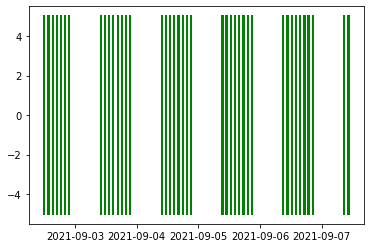

In [90]:
fig_tv_rgt = plt.figure("Time in View RGT")
ax_tv_rgt = fig_tv_rgt.add_subplot(111)

visibility_start_rgt = elehandler_rgt.times.get("start").copy()
visibility_end_rgt = elehandler_rgt.times.get("end").copy()
if visibility_start_rgt[0] > visibility_end_rgt[0]:
    visibility_start_rgt.insert(0, start_time_rgt)
tv_rgt = []



for tv_start_rgt, tv_end_rgt in zip(visibility_start_rgt, visibility_end_rgt):
    ax_tv_rgt.plot([tv_start_rgt, tv_start_rgt], [-5, 5], color='green', linewidth=2)
    ax_tv_rgt.plot([tv_start_rgt, tv_end_rgt], [0, 0], color='red', linewidth=1)
    ax_tv_rgt.plot([tv_end_rgt, tv_end_rgt], [-5, 5], color='green', linewidth=2)
    tv_rgt.append((tv_end_rgt-tv_start_rgt).total_seconds())

avg_tv_rgt = np.mean(tv_rgt)
fraction_tv_rgt = np.sum(tv_rgt)/duration
print(f"fraction of time in view of RGT Orbit: {fraction_tv_rgt}")
print(f"average overpass time of RGT Orbit: {avg_tv_rgt/60} mins")

In [91]:
elehandler_rgt.times.get("start")[1] 

datetime.datetime(2021, 9, 2, 15, 7, 8, 870454)

In [92]:
start_time_rgt

datetime.datetime(2021, 9, 2, 11, 51, 34, 125257)

In [93]:
elehandler_rgt.times.get("end")[2]

datetime.datetime(2021, 9, 2, 15, 10, 15, 926601)

#### Gap times

In [94]:
gap_times_rgt = np.array(visibility_start_rgt[1:]) - np.array(visibility_end_rgt[:-1])
gap_times_seconds_rgt = [g.total_seconds() for g in gap_times_rgt]
max_gap_time_rgt = np.max(gap_times_seconds_rgt)
time_avg_gap_rgt = np.linalg.norm(gap_times_seconds_rgt)**2/duration

print(f"Maximum gap time for RGT Orbit: {max_gap_time_rgt/3600} hrs")
print(f"Average gap time for RGT Orbit: {time_avg_gap_rgt/3600} hrs")

Maximum gap time for RGT Orbit: 12.204036625277778 hrs
Average gap time for RGT Orbit: 6.881316970621864 hrs


#### Coverage

##### Footprint Area

Average Footprint area of RGT Orbit is 110509.79179267643 sq km


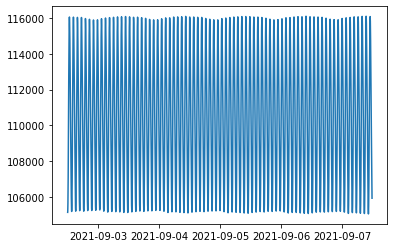

In [95]:
fig_fp_rgt = plt.figure("Footprint Area RGT")
ax_fp_rgt = fig_fp_rgt.add_subplot(111)
ax_fp_rgt.plot(time_vec, np.array(phandler_rgt.fp_area)/1e6)

print(f"Average Footprint area of RGT Orbit is {np.mean(np.array(phandler_rgt.fp_area))/1e6} sq km")

##### Access Area

Average Access area of RGT Orbit is 12185464.993680917 sq km


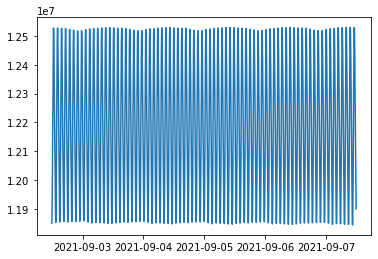

In [96]:
fig_ar_rgt = plt.figure("Access Area RGT")
ax_ar_rgt = fig_ar_rgt.add_subplot(111)
ax_ar_rgt.plot(time_vec, phandler_rgt.access_area) # access area in km2
print(f"Average Access area of RGT Orbit is {np.mean(np.array(phandler_rgt.access_area))} sq km")

#### Eclipse

In [97]:
day_night_event_handler_rgt.night_starts[0]

datetime.datetime(2021, 9, 2, 12, 11, 16, 421737)

In [98]:
night_day_event_handler_rgt.night_ends[0]

datetime.datetime(2021, 9, 2, 12, 46, 15, 878229)

In [99]:
eclipse_durations_rgt = None
if day_night_event_handler_rgt.night_starts[0] > night_day_event_handler_rgt.night_ends[0]:
    print("First event recorded is end of eclipse. We discard the first value from end.")
    eclipse_durations_rgt = (np.array(night_day_event_handler_rgt.night_ends[1:]) - np.array(day_night_event_handler_rgt.night_starts))
else:
    print("First event recorded is start of eclipse.")
    eclipse_durations_rgt = np.array(night_day_event_handler_rgt.night_ends) - np.array(day_night_event_handler_rgt.night_starts)
eclipse_durations_rgt_sec = np.array([t.total_seconds() for t in eclipse_durations_rgt])
mean_eclipse_duration_rgt = np.mean(eclipse_durations_rgt_sec)
fraction_eclipse_rgt = np.sum(eclipse_durations_rgt_sec)/duration

print(f"Mean Eclipse Duration of RGT is {mean_eclipse_duration_rgt/60} mins")
print(f"Fraction Eclipse Duration of RGT is {fraction_eclipse_rgt}")

First event recorded is start of eclipse.
Mean Eclipse Duration of RGT is 34.13453408092106 mins
Fraction Eclipse Duration of RGT is 0.3603089708541667


In [100]:
neubiberg_pass_rgt = list(filter(lambda g: g.getLatitude()==LATITUDE_NEUBIBERG and g.getLongitude()==LONGITUDE_NEUBIBERG, phandler_rgt.centers))